In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"


import jax.numpy as jnp
import numpy as np
import pytest
import jax
from jax import random

from bpd.pipelines.shear_inference import pipeline_shear_inference, logtarget_density
from bpd.pipelines.toy_ellips import pipeline_toy_ellips_samples
from bpd.likelihood import shear_loglikelihood

from bpd.prior import ellip_mag_prior
from bpd.chains import run_inference_nuts


from jax import jit

from functools import partial

import matplotlib.pyplot as plt


In [2]:
seed = 42

In [3]:
key = random.key(seed)
k1, k2 = random.split(key)

g1 = 0.02
g2 = 0.0
sigma_e = 1e-3
sigma_m = 1e-5
sigma_e_int = 3e-2

2024-12-02 07:57:11.683848: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
e_post = pipeline_toy_ellips_samples(
    k1,
    g1=g1,
    g2=g2,
    sigma_e=sigma_e,
    sigma_e_int=sigma_e_int,
    sigma_m=sigma_m,
    n_gals=1000,
    n_samples_per_gal=100,
)[0]
assert e_post.shape == (1000, 100, 2)
e_post_trimmed = e_post[:, ::10, :]

In [6]:
from jax import Array
from typing import Callable
from jax.scipy import stats


def logtarget_density(params, *, data: Array, loglikelihood: Callable):
    e_post = data  # comptability with `do_inference_nuts`
    
    g1 = params['g1']
    g2 = params['g2']
    g = jnp.array([g1, g2])
    
    sigma_e = params['sigma_e']
    
    loglike = loglikelihood(g, sigma_e, e_post)
    logprior = stats.uniform.logpdf(g, -0.1, 0.2).sum() + stats.uniform.logpdf(sigma_e, 1e-5, 1. - 1e-5)
    return logprior + loglike

In [7]:
_loglikelihood = jit(
    partial(shear_loglikelihood, prior = ellip_mag_prior, 
            interim_prior=partial(ellip_mag_prior, sigma=sigma_e_int))
)
_logtarget = partial(logtarget_density, loglikelihood=_loglikelihood)

In [8]:
_do_inference = partial(
    run_inference_nuts,
    data=e_post_trimmed,
    logtarget=_logtarget,
    n_samples=3000,
    n_warmup_steps=500,
    max_num_doublings=2,
    initial_step_size=1e-2,
)

In [9]:
samples = _do_inference(k2, {'g1':g1*3, 'g2':g2, 'sigma_e':sigma_e*3})

In [10]:
samples['g1'].shape, samples['sigma_e'].shape

((3000,), (3000,))

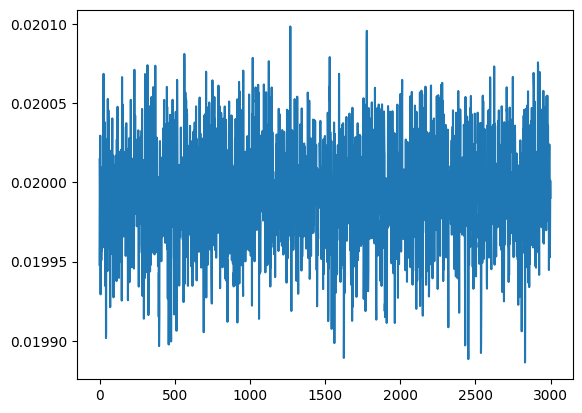

In [11]:
plt.plot(samples['g1'])

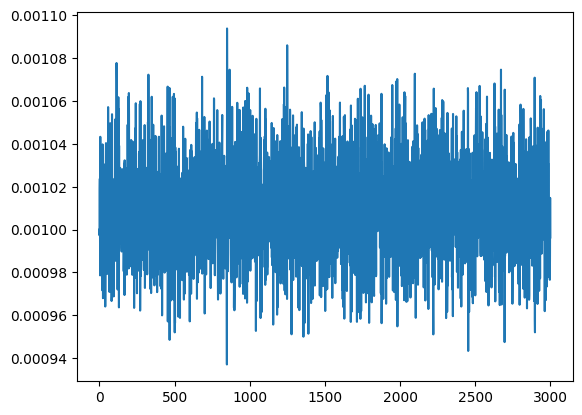

In [12]:
plt.plot(samples['sigma_e'])

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


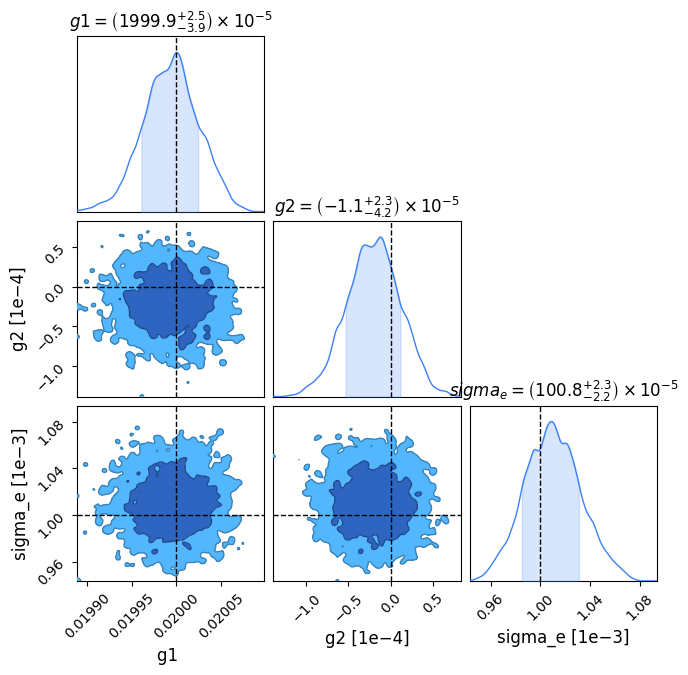

In [13]:
# contour plots
from bpd.diagnostics import get_contour_plot

_ = get_contour_plot([samples], ['posterior'], {'g1':g1, 'g2':g2, 'sigma_e':sigma_e})


In [28]:
samples['g1'].std(), 1e-3 / jnp.sqrt(1000)

(Array(3.14792718e-05, dtype=float64),
 Array(3.16227766e-05, dtype=float64, weak_type=True))